# SC3000 Project

## Project Information

### The Cart Pole Environment
The cart pole environment consists of a cart that can move linearly and a rotating pole attached to it via a bearing
### The Objective

<div>
<img src="./assets/images/problem_diagram.png" width="500"/>
</div>

The control objective is to keep the pole in the verical position by applying horizontal actions to the cart. The set of actions one can perform are:
1. Pushing the cart left
2. Pushing the cart right

The variables which determine what actions to take depend on
* Cart Position (-4.8 to 4.8)
* Cart Velocity (-∞ to ∞)
* Pole angle of rotation (-24 degrees to 24 degrees)
* Pole angular velocity (-∞ to ∞)

An episode terminates when:
1. The Pole angle becomes greater than ± 12 degrees
2. Cart position is greater than ± 2.4

## Installing and Importing Dependencies

In [16]:
%pip install gymnasium 
%pip install matplotlib
%pip install pygame
%pip install tqdm
%pip install moviepy

import numpy as np
import gymnasium as gym
from gym.wrappers import RecordVideo
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import Video

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Task 1: Developing RL Agent

### Discretising the statespace

The state space for our Cart Pole system is not discrete. The state of *(θ, ω, x, v)* is continuous, which mean that we have an infinite number of action-value functions. Hence, we want to approximate a continuous state-space by a finite discrete state-space.

To achieve this, we can divide the state into a number of segments and the assign each continuous state vector to a set of discrete indices. This process produces a Q-matrix.

<div>
<img src="./assets/images/Q-table_with_discretisation.png" width="400"/>
</div>

By using the Q-table we can run the algorithm. First, we observe the state S, then, we discretize this state, to obtain discrete indices ($ I_{x},I_{v},I_{\theta},I_{w} $). Then, we can use these discrete indices to select a row of the Q-table, that represents the action value function values for certain actions. By using this type of discretization and indexing we can run the Q-learning algorithm.

In [3]:
## parameters for state discretisation
env = gym.make('CartPole-v1')
upper_bounds = env.observation_space.high
lower_bounds = env.observation_space.low

cart_position_lower_bound = lower_bounds[0] 
cart_veloctiy_lower_bound = -3 
pole_angle_lower_bound = lower_bounds[2] 
pole_angular_velocity_lower_bound = -10 

cart_position_upper_bound = upper_bounds[0] 
cart_velocity_upper_bound = 3 
pole_angle_upper_bound = upper_bounds[2] 
pole_angular_velocity_upper_bound = 10 

cart_position_number_of_bins = 30
cart_velocity_number_of_bins = 30
pole_angle_number_of_bins = 30
pole_angular_velocity_number_of_bins = 30

global cart_position_bin
global cart_velocity_bin
global pole_angle_bin
global pole_angular_velocity_bin

# numpy.linspace(start, stop, num=50) 
# numpy.linspace: Returns num evenly spaced samples, calculated over the interval [start, stop]
# https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
cart_position_bin = np.linspace(cart_position_lower_bound, cart_position_upper_bound, cart_position_number_of_bins)
cart_velocity_bin = np.linspace(cart_veloctiy_lower_bound, cart_velocity_upper_bound, cart_velocity_number_of_bins)
pole_angle_bin = np.linspace(pole_angle_lower_bound, pole_angle_upper_bound, pole_angle_number_of_bins)
pole_angular_velocity_bin = np.linspace(pole_angular_velocity_lower_bound, pole_angular_velocity_upper_bound, pole_angular_velocity_number_of_bins)

env.close()

### Epsilon-Greedy Algorithm

Here's the epsilon-greedy algorithm with a more mathematical twist:

At each decision step:

1. **Exploration vs Exploitation:**
   - Generate a random number *u* uniformly distributed between 0 and 1.

2. **Exploration (with probability ε):**
   - If *u* ≤ ε:
      - Select an action *a* randomly from set *A*.

3. **Exploitation (with probability 1-ε):**
   - If *u* > ε:
      - Choose the action *a* with the highest estimated Q-value:
        *a = argmax(Q(a)) for all a ∈ A*

This translates to selecting an action based on a probability distribution:

**Action Selection Probability:**
  - P(choosing a) = (1 - ε) if Q(a) = max(Q(b)) for all b ∈ A
  - P(choosing a) = ε / |A| otherwise


In [4]:
def calculate_action(episode_count, action_number, epsilon, q_matrix, current_state_index):
    # generates a random number from [0.0, 1.0)
    # used to determine epsilon greedy approach
    # https://aleksandarhaber.com/explanation-and-python-implementation-of-on-policy-sarsa-temporal-difference-learning-reinforcement-learning-tutorial/
    random_number = np.random.random()

    if episode_count < 500 or random_number < epsilon:
        return np.random.choice(action_number)

    else:
        # numpy.argmax(a, axis=None, out=None, *, keepdims=<no value>)
        # Returns the indices of the maximum values along an axis
        # e.g. numpy.argmax([0, 1, 2, 5, 3, 4])
        # output: 3
        return np.argmax(q_matrix[current_state_index])

### Q-learning Algorithm

For every time step of a single episode (until the terminal state is reached):

Step 1: Select action A in the state S with the epsilon-greedy algorithm. 

Step 2: Apply action A to the environment, and observe the reward R and the next state S'.

Step 3: Update the action value function: 

- If the next state S' is not the terminal state   
$$ \begin{align*}         Q(S,A)& \leftarrow Q(S,A) +\alpha \Big(R+\gamma Q_{\text{max}}-Q(S,A) \Big) \\Q_{\text{max}} & =\text{max}_{a} Q(S',a) \end{align*} $$


- If the next state S' is the terminal state  
$$ \begin{align*}         Q(S,A)& \leftarrow Q(S,A) +\alpha \Big(R-Q(S,A) \Big) \\\end{align*} $$


Step 4: Set S=S’ and start again from Step 1.

Once the algorithm is executed for a number of episodes, we compute the action value function Q(S,A). Then, we select the action A in state S simply as
   
$$\begin{align*}A(S)=\text{argmax}_{A}Q(S,A)\end{align*} $$

That is, we select the action A in a particular state that produces the maximal value of the action value function at that state


In [5]:
def calculate_state_index(state):
    cart_position = state[0]
    cart_velocity = state[1]
    pole_angle = state[2]
    pole_angular_velocity = state[3]

    # numpy.digitize(x, bins, right=False)
    # Return the indices of the bins to which each value in input array belongs.
    # https://numpy.org/doc/stable/reference/generated/numpy.digitize.html
    cart_position_index = np.maximum(np.digitize(cart_position, cart_position_bin)-1, 0)
    cart_velocity_index = np.maximum(np.digitize(cart_velocity, cart_velocity_bin)-1, 0)
    pole_angle_index = np.maximum(np.digitize(pole_angle, pole_angle_bin)-1, 0)
    pole_angular_velocity_index = np.maximum(np.digitize(pole_angular_velocity, pole_angular_velocity_bin)-1, 0)

    return tuple([cart_position_index, cart_velocity_index, pole_angle_index, pole_angular_velocity_index])

In [6]:
def q_learning(current_state, episode_count, env, epsilon, number_of_actions, q_matrix, gamma, alpha):
    
    episode_reward = []
    
    terminated = False
    while not terminated:
        current_state_index = calculate_state_index(current_state)
        # print(epsilon) # debug
        action = calculate_action(episode_count, number_of_actions, epsilon, q_matrix, current_state_index)
        # print(action) # debug
        next_state, reward, terminated, _, _ = env.step(action)
        episode_reward.append(reward)
        next_state = list(next_state)
        next_state_index = calculate_state_index(next_state)
        q_max = np.max(q_matrix[next_state_index])

        # calculate error
        if not terminated:
            error = reward + gamma * q_max - q_matrix[current_state_index + (action,)]
        else:
            error = reward - q_matrix[current_state_index + (action,)]

        # update Q value
        q_matrix[current_state_index + (action,)] += alpha * error
        current_state = next_state
    
    return episode_reward, q_matrix

### Simulate Learning Stage

In [7]:
# constants
number_of_episodes = 5000
gamma = 1
alpha = 0.1
epsilon = 0.2

env = gym.make('CartPole-v1')
state, _ = env.reset()
number_of_actions = env.action_space.n
q_matrix = np.random.uniform(low=0, high=1, size=(cart_position_number_of_bins, cart_velocity_number_of_bins, pole_angle_number_of_bins, pole_angular_velocity_number_of_bins, number_of_actions))

all_episodes_reward = []

for episode_count in tqdm(range(number_of_episodes)):
    state, _ = env.reset()
    state = list(state)
    # print(f"Episode Count: {episode_count}") # debug
    
    # at half the total episodes, slowly reduce epsilon values to prioritise exploitation over exploration
    if episode_count > number_of_episodes//2: 
        epsilon = 0.999 * epsilon

    episode_reward, q_matrix = q_learning(state, episode_count,  env, epsilon, number_of_actions, q_matrix, gamma, alpha)
    all_episodes_reward.append(np.sum(episode_reward))

env.close()

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [01:05<00:00, 76.72it/s] 


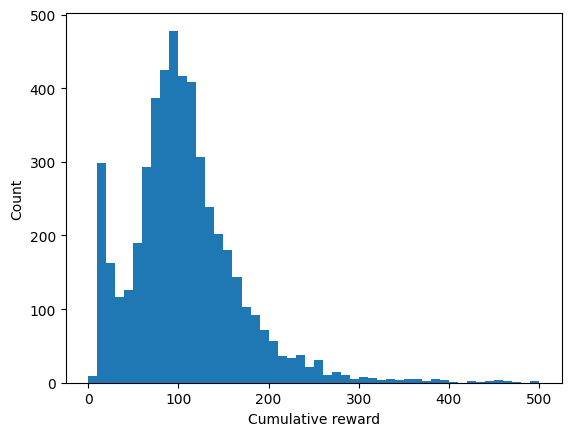

In [8]:
plt.hist(all_episodes_reward, bins=50, range=(0,500))
plt.xlabel('Cumulative reward')
plt.ylabel('Count')
plt.show()

## Task 2: Effectiveness of RL Agent

In [9]:
def calculate_greedy_action(q_matrix, current_state_index):
    action = np.argmax(q_matrix[current_state_index])
    
    return action

In [10]:
env = gym.make('CartPole-v1')

number_of_episodes = 100
cumulative_episodes_reward = []

for episode_count in tqdm(range(number_of_episodes)):
    current_state, _ = env.reset()
    total_rewards = []
    terminated = False
    while not terminated:
        current_state_index = calculate_state_index(current_state)
        action = calculate_greedy_action(q_matrix, current_state_index)
        next_state, reward, terminated, _, _ = env.step(action)
        total_rewards.append(reward)
        current_state = next_state

    cumulative_episodes_reward.append(np.sum(total_rewards))

env.close()

100%|██████████| 100/100 [00:03<00:00, 32.20it/s]


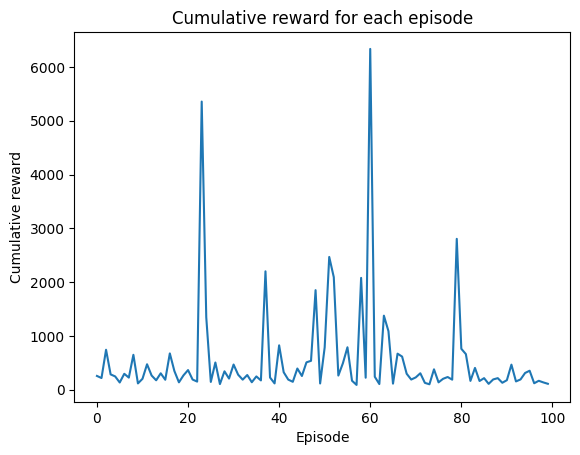

In [11]:
# plt.figure(figsize=(12, 5))
# plot the figure and adjust the plot parameters
# plt.plot(all_episodes_reward, color='blue', linewidth=1)
plt.plot(cumulative_episodes_reward)
plt.title('Cumulative reward for each episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative reward')
# plt.yscale('log')
# plt.savefig('convergence.png')
plt.show()

In [12]:
average_episodes_reward = np.mean(cumulative_episodes_reward)
print(f'Average cumulative reward: {average_episodes_reward}')
print(f"Is my agent good enough: {average_episodes_reward > 195}")

Average cumulative reward: 547.62
Is my agent good enough: True


## Task 3: Simulate one episode of developed RL Agent

In [22]:
def simulate_learned_strategy(q_matrix):
    env = gym.make("CartPole-v1", render_mode="rgb_array")  # replace with your environment
    env = RecordVideo(env, video_folder="./videos", name_prefix="eval", episode_trigger=lambda x: True)
    
    current_state, _ = env.reset()
    env.start_video_recorder()
    total_rewards = []
    terminated = False
    while not terminated:
        current_state_index = calculate_state_index(current_state)
        action = calculate_greedy_action(q_matrix, current_state_index)
        next_state, reward, terminated, _, _ = env.step(action)
        total_rewards.append(reward)
        current_state = next_state
        time.sleep(0.05)

    time.sleep(1)
    env.close()
    env.close_video_recorder()
    return total_rewards

total_rewards = simulate_learned_strategy(q_matrix)

c:\Users\Jovan\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at c:\Users\Jovan\Documents\repos\sc3000-project\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\Jovan\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_wrapper_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video c:\Users\Jovan\Documents\repos\sc3000-project\videos\eval-episode-0.mp4.
Moviepy - Writing video c:\Users\Jovan\Documents\repos\sc3000-project\videos\eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jovan\Documents\repos\sc3000-project\videos\eval-episode-0.mp4


Moviepy - Building video c:\Users\Jovan\Documents\repos\sc3000-project\videos\eval-episode-0.mp4.
Moviepy - Writing video c:\Users\Jovan\Documents\repos\sc3000-project\videos\eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jovan\Documents\repos\sc3000-project\videos\eval-episode-0.mp4
565.0


In [23]:
print(np.sum(total_rewards))
Video("videos/eval-episode-0.mp4")

565.0
